In [356]:
import datetime
import importlib
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import utils
from utils.download import get_data

In [357]:
_ = importlib.reload(utils.download)

In [358]:
data, params = get_data()

[*********************100%%**********************]  1 of 1 completed


In [359]:
data['returns'] = data.interpolate(type='linear').pct_change()

In [360]:
train, test = data.loc[:params['test']-datetime.timedelta(days=1), ], data.loc[params['test']:, ]

# Metoda historyczna

In [361]:
alpha = .95

In [454]:
data['var95'] = data.returns.rolling(window=125).quantile(alpha)
data['VaR95'] = data.var95 * data.Close.shift(-1) + data.Close.shift(-1)

Wykres zwrotów i VaR95 dla zwrotów.

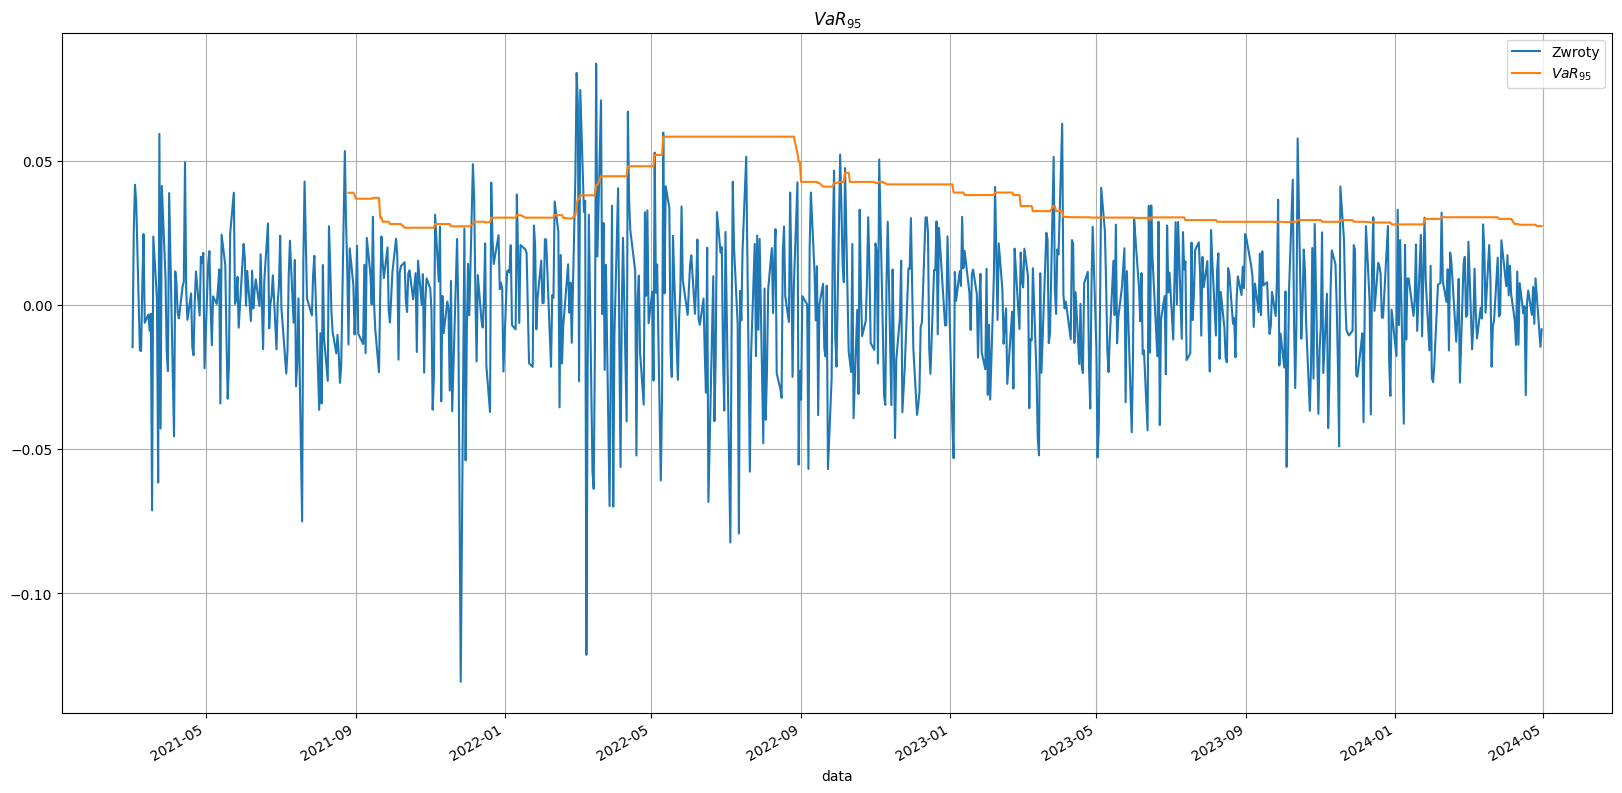

In [458]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

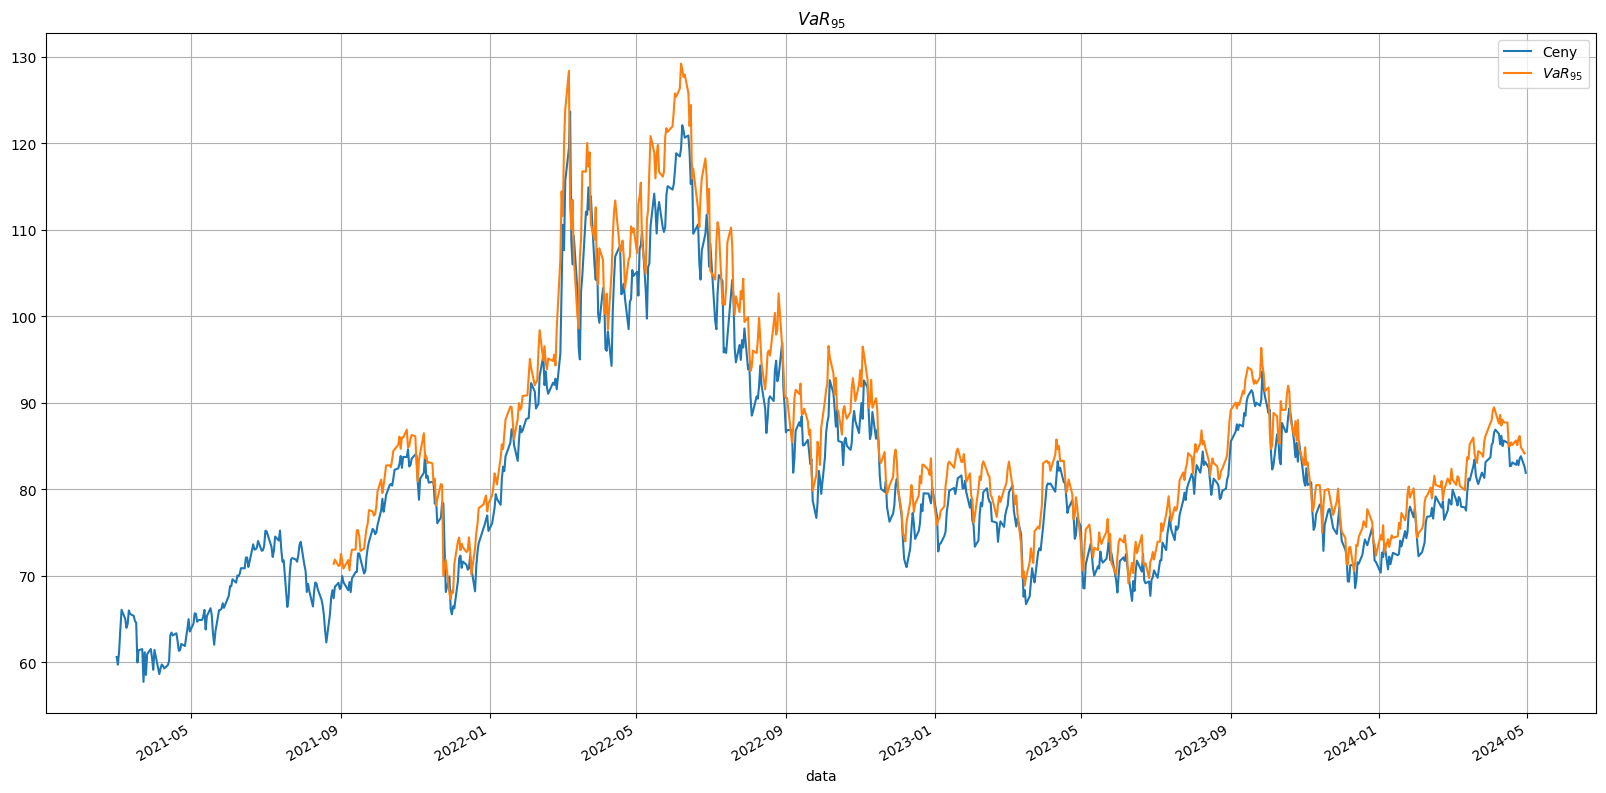

In [462]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [364]:
data['exceeds'] = np.where(data['returns'] > data['var95'], 1, 0)
data.loc[data['var95'].isna(), 'exceeds'] = np.nan
data['procent przekroczeń'] = data.exceeds.rolling(window=50).sum()/50

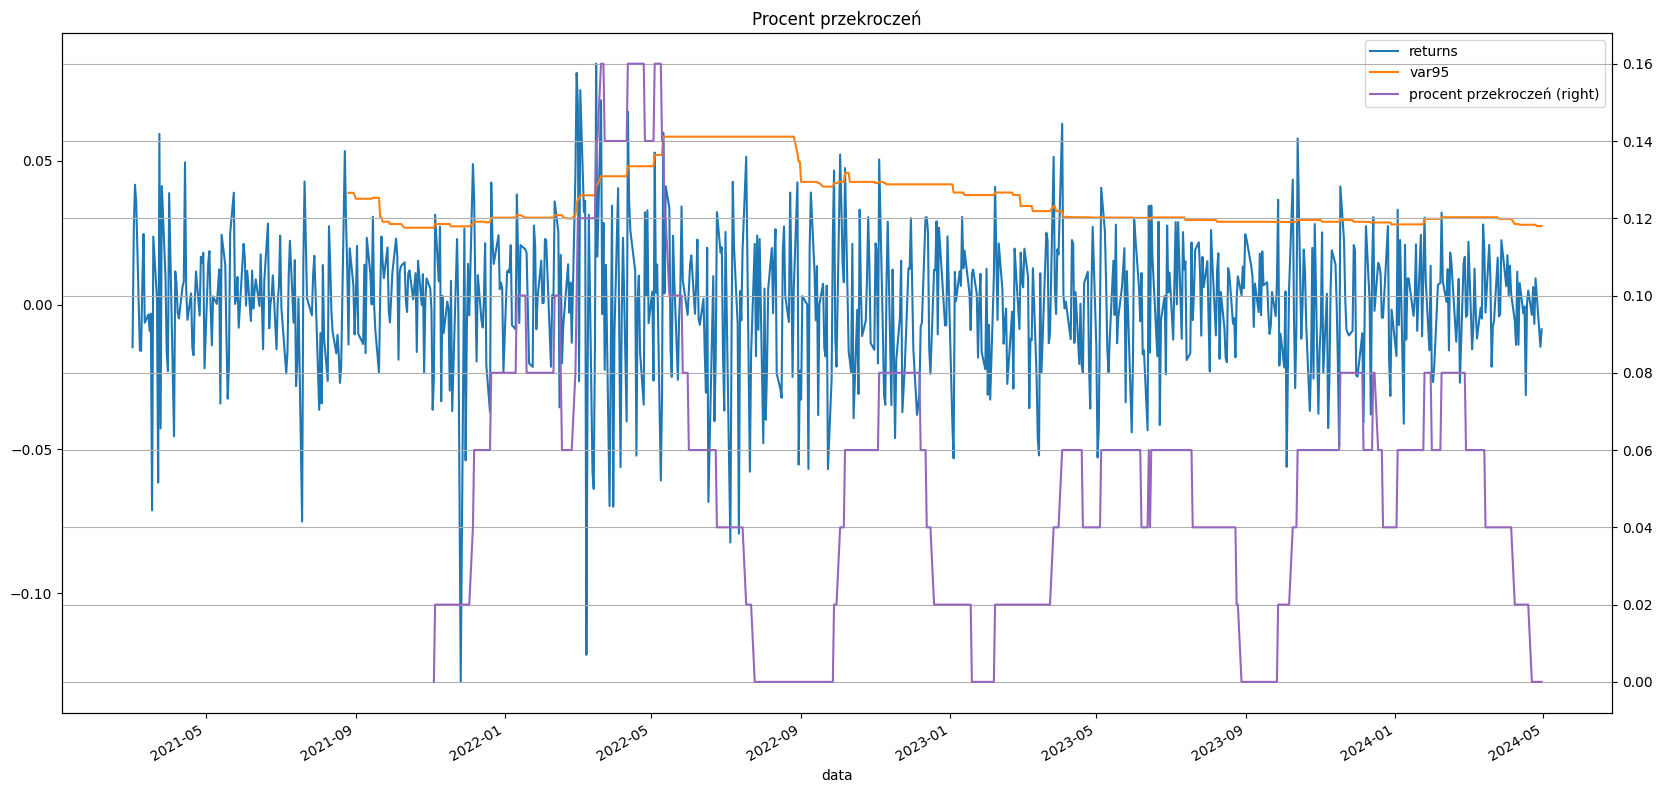

In [463]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95', 'procent przekroczeń']].\
    plot(ax=ax,
         secondary_y=['procent przekroczeń'],
         grid=True,
         style=['-', '-', '-'],
         color=['C0', 'C1', 'C4'],
         xlabel='data',
         title='Procent przekroczeń')
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

In [416]:
I = data.dropna().exceeds # wektor przekroczeń

### Rozkład dwumianowy

In [367]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'.\
    format(*map(lambda x: np.round(x, 3),
                [I.mean(), alpha, 1- alpha,
                 I.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.053, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.05, 0.95(1 - 0.95) = 0.048.


In [368]:
stats.binomtest(int(I.sum()), n=I.size, p=1-alpha)

BinomTestResult(k=33, n=625, alternative='two-sided', statistic=0.0528, pvalue=0.7134330775466879)

# Metoda ważonej symulacji historycznej

In [369]:
lam = params['lambda']
alpha = 0.95

In [370]:
def weighted_var(losses):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()
    return df.loc[df.weights.searchsorted(alpha)-1, 'losses']

In [371]:
data['var95_ważony'] = data.returns.rolling(window=125).agg(weighted_var)

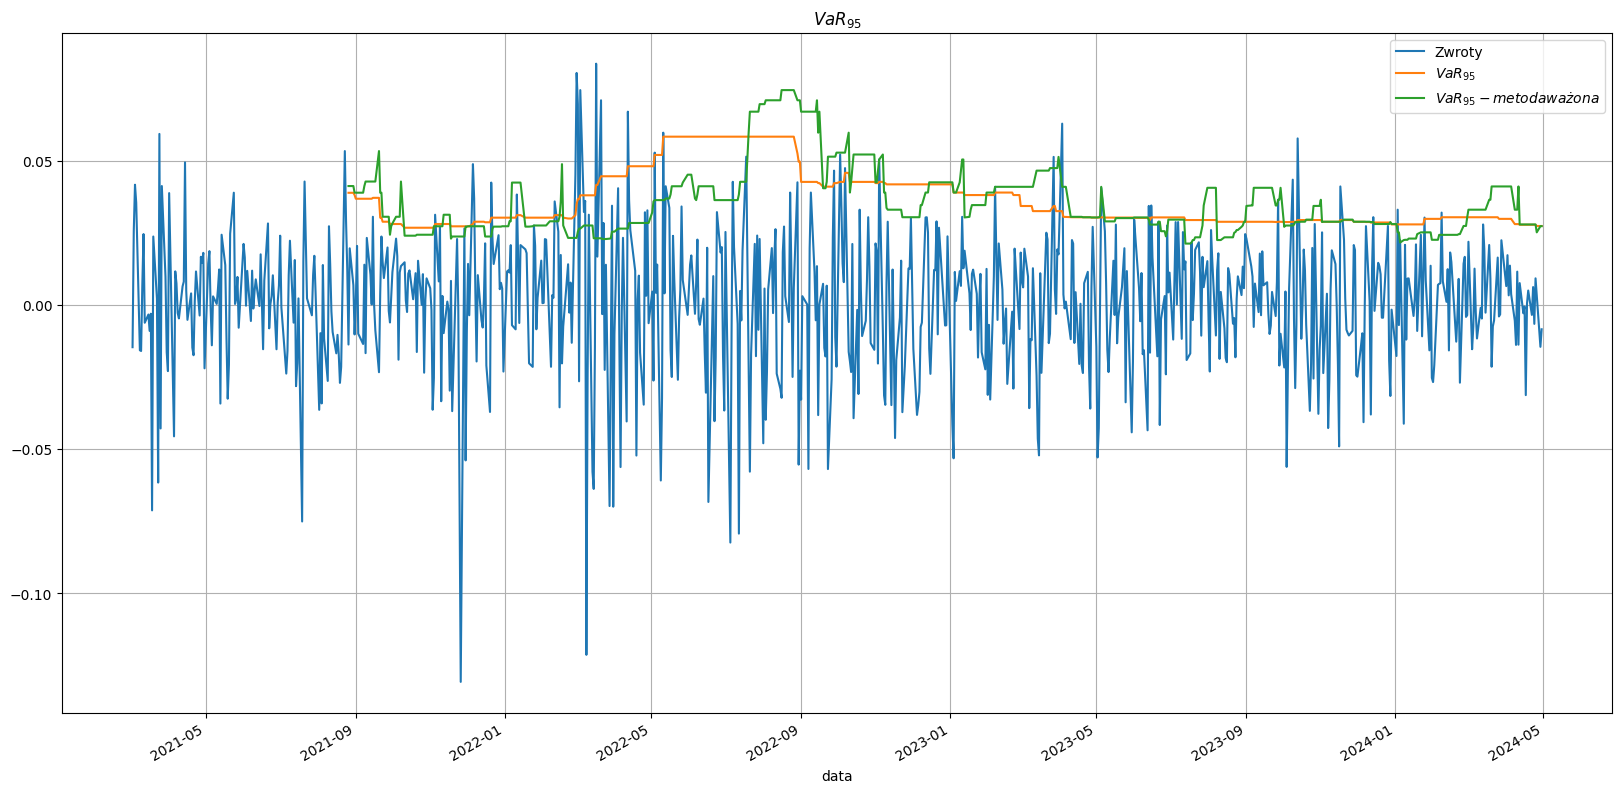

In [464]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95','var95_ważony']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95} - metoda ważona$'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

In [373]:
data['exceeds_ważony'] = np.where(data['returns'] > data['var95_ważony'], 1, 0)
data.loc[data['var95_ważony'].isna(), 'exceeds_ważony'] = np.nan
data['procent przekroczeń (ważony)'] = data.exceeds_ważony.rolling(window=50).sum() / 50

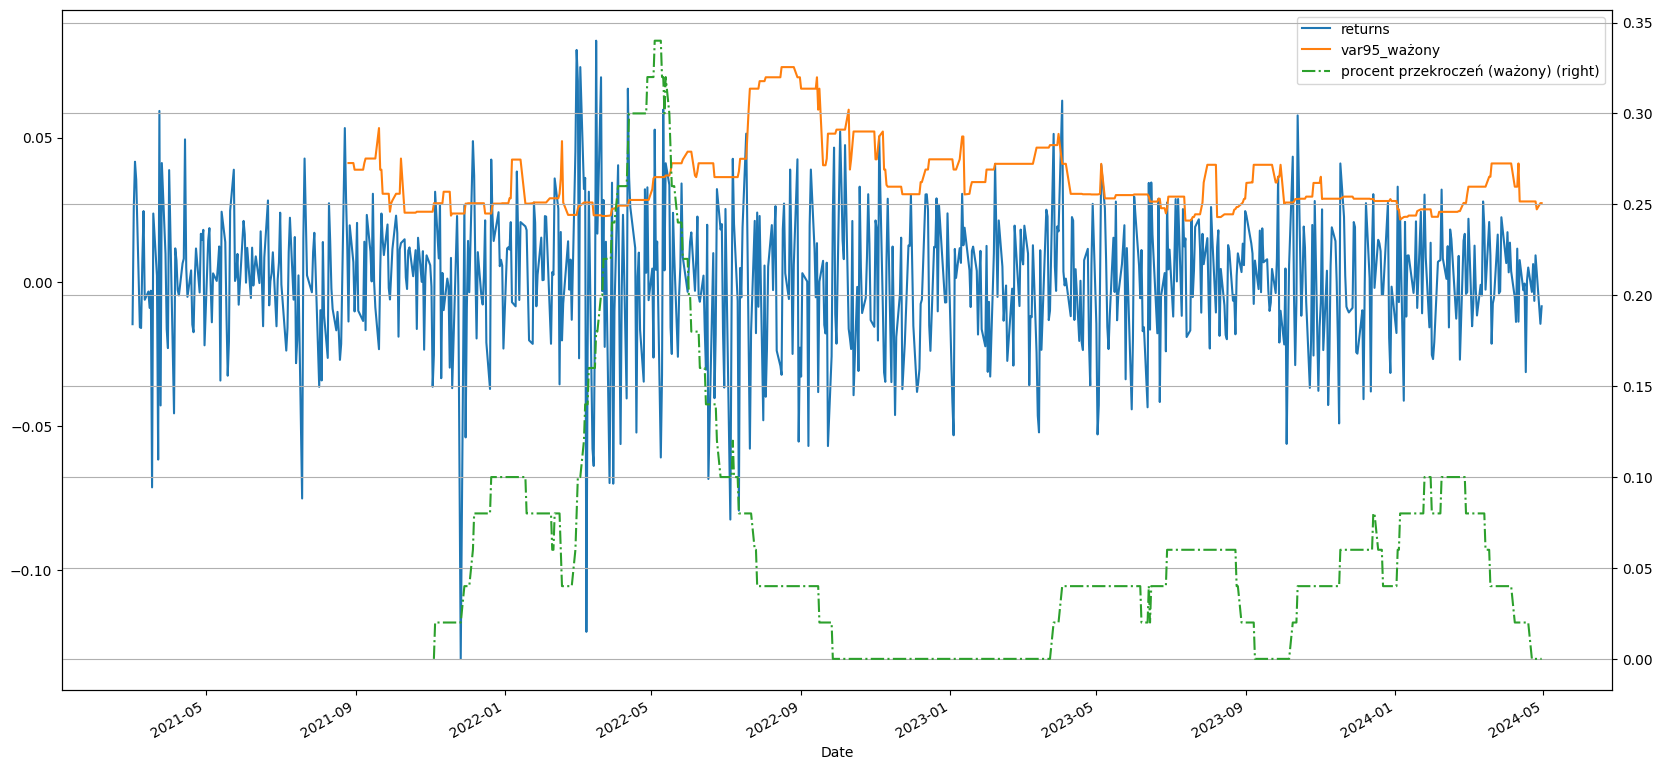

In [374]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważony', 'procent przekroczeń (ważony)']].\
    plot(ax=ax, secondary_y=['procent przekroczeń (ważony)'], grid=True,
         style=['-', '-', '-.'])

## Testowanie wsteczne

In [375]:
I_w = data.dropna().exceeds_ważony # wektor przekroczeń metoda ważona

### Rozkład dwumianowy

In [376]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_w.mean(), alpha, 1 - alpha,
                   I_w.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.064, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.06, 0.95(1 - 0.95) = 0.048.


In [377]:
stats.binomtest(int(I_w.sum()), n=I_w.size, p=1-alpha)

BinomTestResult(k=40, n=625, alternative='two-sided', statistic=0.064, pvalue=0.11766255670936215)

# Metoda filtrowanej symulacji historycznej

In [378]:
from arch import arch_model

In [394]:
def garch_var(losses):
    losses = losses.dropna() * 100
    model =  arch_model(losses, vol ="GARCH", p=1, q=1, dist="t", mean='constant')
    res = model.fit()
    forecasts = res.forecast(horizon=1)
    variance = forecasts.variance.values[0, 0]
    mean = forecasts.mean.values[0, 0]
    residuals = (res.resid - mean) / res.conditional_volatility
    q = residuals.quantile(alpha)
    return (mean + np.sqrt(variance) * q) / 100

In [405]:
%%capture
data['var95_garch'] = data.returns.rolling(window=125).agg(garch_var)

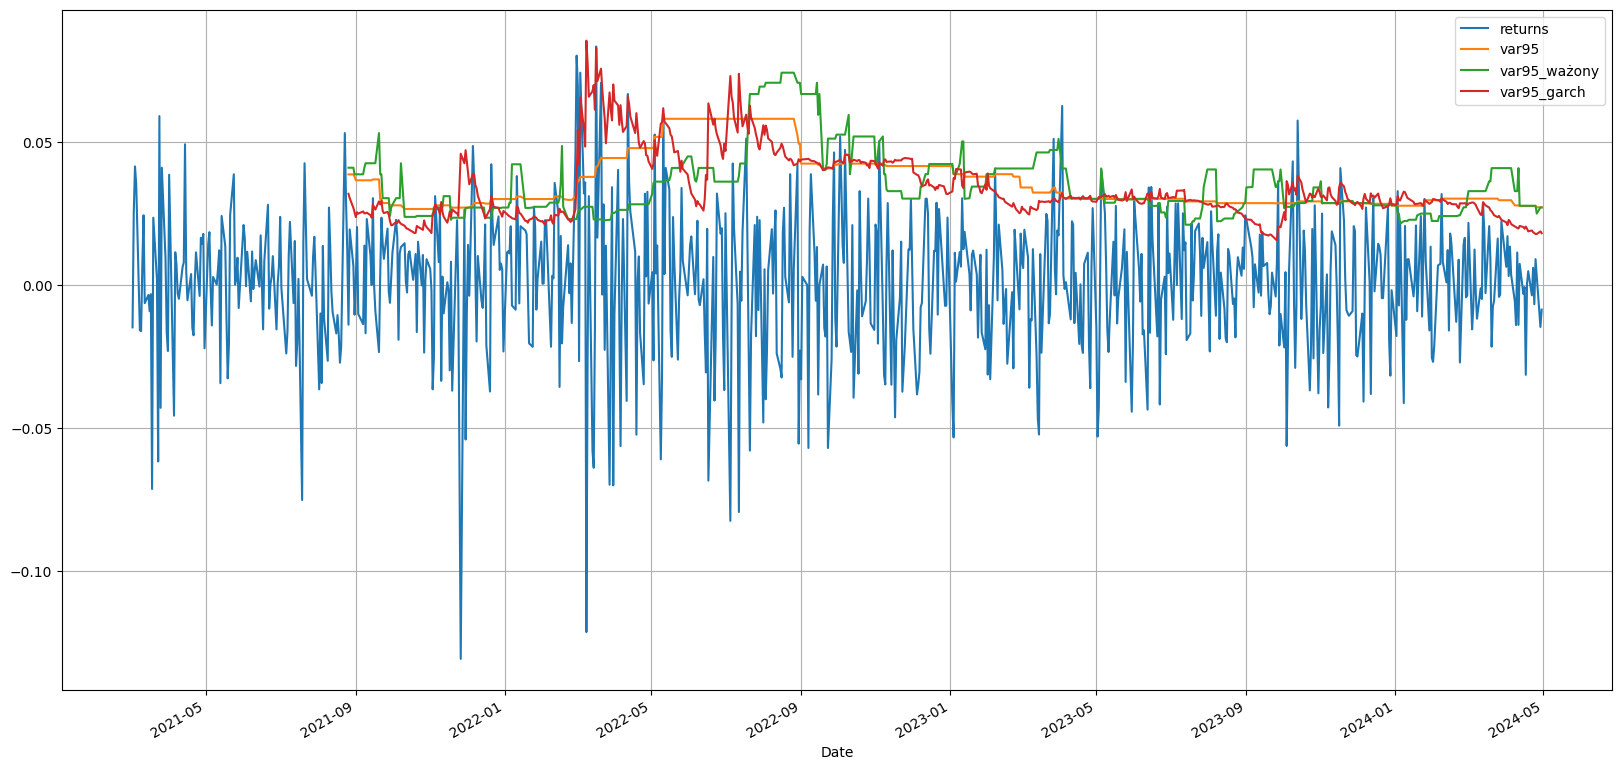

In [406]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95', 'var95_ważony', 'var95_garch']].plot(grid=True, ax=ax)

In [407]:
data['exceeds_garch'] = np.where(data['returns'] > data['var95_garch'], 1, 0)
data.loc[data['var95_garch'].isna(), 'exceeds_garch'] = np.nan
data['procent przekroczeń (garch)'] = data.exceeds_ważony.rolling(window=50).sum() / 50

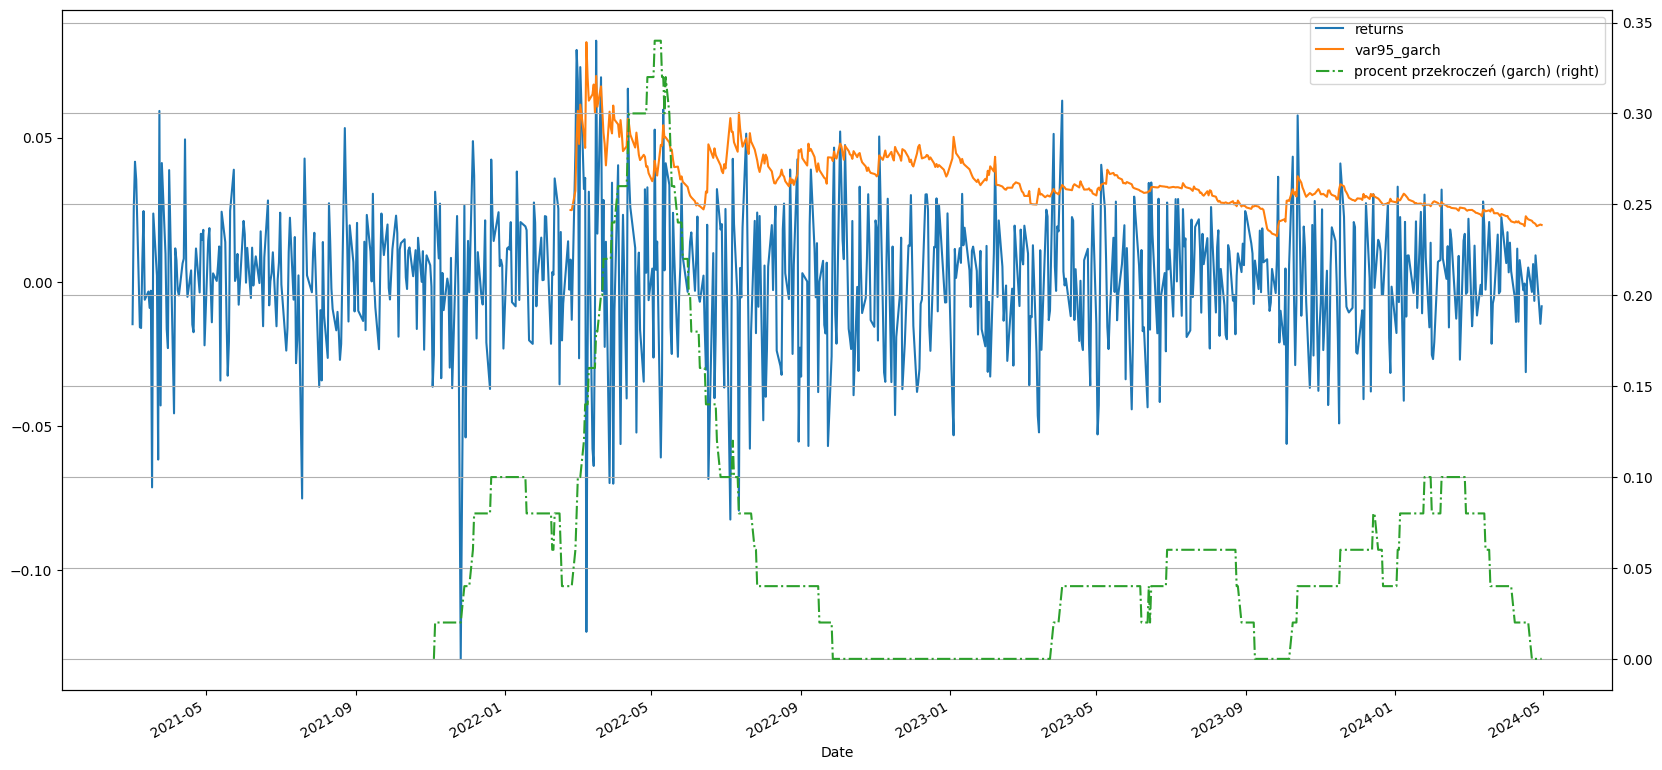

In [404]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_garch', 'procent przekroczeń (garch)']]. \
    plot(ax=ax, secondary_y=['procent przekroczeń (garch)'], grid=True,
         style=['-', '-', '-.'])

## Testowanie wsteczne

In [408]:
I_g = data.dropna().exceeds_garch # wektor przekroczeń metoda ważona

### Rozkład dwumianowy

In [409]:
print('Średnia z przekroczeń = {}, 1 - {} = {}.\nWariancja z przekroczeń = {}, {}(1 - {}) = {}.'. \
      format(*map(lambda x: np.round(x, 3),
                  [I_g.mean(), alpha, 1 - alpha,
                   I_g.var(), alpha, alpha, alpha * (1 - alpha)])))

Średnia z przekroczeń = 0.054, 1 - 0.95 = 0.05.
Wariancja z przekroczeń = 0.052, 0.95(1 - 0.95) = 0.048.


In [410]:
stats.binomtest(int(I_g.sum()), n=I_g.size, p=1-alpha)

BinomTestResult(k=34, n=625, alternative='two-sided', statistic=0.0544, pvalue=0.5817943087638204)